Epoch: 0 Cost: 0.20094755291938782
Epoch: 1000 Cost: 0.2002227008342743
Epoch: 2000 Cost: 0.18092310428619385
Epoch: 3000 Cost: 0.10112883150577545
Epoch: 4000 Cost: 0.03811695799231529
Epoch: 5000 Cost: 0.02091827802360058
Epoch: 6000 Cost: 0.01523100957274437
Epoch: 7000 Cost: 0.01353136170655489
Epoch: 8000 Cost: 0.012329292483627796
Epoch: 9000 Cost: 0.011765015311539173


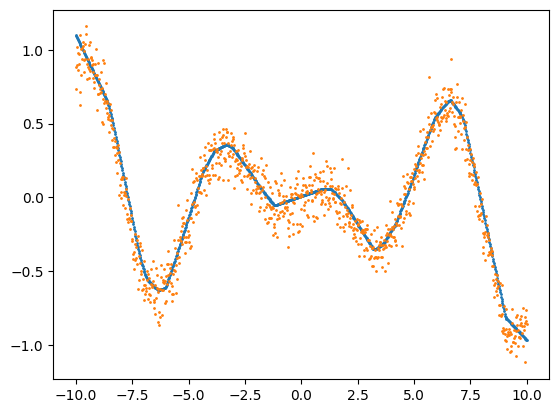

In [3]:
from jax import random
from jax import grad, jit, vmap
from typing import Tuple
import jax.numpy as jnp
import matplotlib.pyplot as plt

keygen = random.PRNGKey(0)

def init_weights(features_in: int, features_out: int, key: random.PRNGKey, scale=1e-2) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return scale * random.normal(key, shape=(features_in, features_out)), scale * random.normal(key, shape=(features_out,))

def relu(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.maximum(x, 0)

def forward(params, x):
    activations = x
    # for all layers except the last one (as we that won't have a relu activation)
    for weights, bias in params[:-1]:
        activations = relu(jnp.dot(jnp.transpose(weights), activations) + bias)

    output_layer_weights, output_layer_bias = params[-1]
    predictions = jnp.dot(jnp.transpose(output_layer_weights), activations) + output_layer_bias
    return predictions


n_features_per_sample = 1
layers = [n_features_per_sample, 32, 32, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
sample = jnp.array([5])
forward(params, sample)
batch = jnp.array([[5], [5]])
batch.shape
vforward = vmap(forward, in_axes=(None, 0))
pred = vforward(params, batch)
labels = jnp.array([10, 10])

def mse_cost(params, x, y):
    predictions = vforward(params, x)
    squared_error = (predictions - y) ** 2
    mse = jnp.mean(squared_error)
    return mse

assert (pred - jnp.reshape(labels, (labels.shape[0], 1))).shape == (2,1)
pred - labels



@jit
def update_params(params, x, y, alpha):
    grads = grad(mse_cost)(params, x, y)
    return [
        (w - alpha * dw, b - alpha * db) for (w, b), (dw, db) in zip(params, grads)
    ]

n_samples = 1000
noise = random.normal(random.PRNGKey(1), (n_samples, ))
x = jnp.linspace(-10, 10, num=1000)
y = 0.1*x*jnp.cos(x) + 0.1*random.normal(random.PRNGKey(1), (1000,))
# plt.scatter(x, y)
x = jnp.reshape(x, (x.shape[0], n_features_per_sample))

y = jnp.reshape(y, (y.shape[0], 1))
layers = [n_features_per_sample, 128, 128, 128, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
learning_rate = 0.1

n_epochs = 10000
costs = []
for epoch in range(n_epochs):
    params = update_params(params, x, y, learning_rate)
    if epoch % 1000 == 0:
        batch_cost = mse_cost(params, x, y)
        print(f"Epoch: {epoch} Cost: {batch_cost}")
        costs.append(batch_cost)


pred = vforward(params, x)
plt.scatter(x, pred, s=1, )
plt.scatter(x, y, s=1)